In [2]:
import requests
import re
import urllib.request
from bs4 import BeautifulSoup
from collections import deque
from html.parser import HTMLParser
from urllib.parse import urlparse
import os

# Regex pattern to match a URL
HTTP_URL_PATTERN = r'^http[s]*://.+'

domain = "openai.com" # <- put your domain to be crawled
full_url = "https://openai.com/" # <- put your domain to be crawled with https or http

# Create a class to parse the HTML and get the hyperlinks
class HyperlinkParser(HTMLParser):
    def __init__(self):
        super().__init__()
        # Create a list to store the hyperlinks
        self.hyperlinks = []

    # Override the HTMLParser's handle_starttag method to get the hyperlinks
    def handle_starttag(self, tag, attrs):
        attrs = dict(attrs)

        # If the tag is an anchor tag and it has an href attribute, add the href attribute to the list of hyperlinks
        if tag == "a" and "href" in attrs:
            self.hyperlinks.append(attrs["href"])

In [3]:
# Function to get the hyperlinks from a URL
def get_hyperlinks(url):

    # Try to open the URL and read the HTML
    try:
        # Open the URL and read the HTML
        with urllib.request.urlopen(url) as response:

            # If the response is not HTML, return an empty list
            if not response.info().get('Content-Type').startswith("text/html"):
                return []

            # Decode the HTML
            html = response.read().decode('utf-8')
    except Exception as e:
        print(e)
        return []

    # Create the HTML Parser and then Parse the HTML to get hyperlinks
    parser = HyperlinkParser()
    parser.feed(html)

    return parser.hyperlinks

In [4]:
# Function to get the hyperlinks from a URL that are within the same domain
def get_domain_hyperlinks(local_domain, url):
    clean_links = []
    for link in set(get_hyperlinks(url)):
        clean_link = None

        # If the link is a URL, check if it is within the same domain
        if re.search(HTTP_URL_PATTERN, link):
            # Parse the URL and check if the domain is the same
            url_obj = urlparse(link)
            if url_obj.netloc == local_domain:
                clean_link = link

        # If the link is not a URL, check if it is a relative link
        else:
            if link.startswith("/"):
                link = link[1:]
            elif link.startswith("#") or link.startswith("mailto:"):
                continue
            clean_link = "https://" + local_domain + "/" + link

        if clean_link is not None:
            if clean_link.endswith("/"):
                clean_link = clean_link[:-1]
            clean_links.append(clean_link)

    # Return the list of hyperlinks that are within the same domain
    return list(set(clean_links))

In [5]:
def crawl(url):
    # Parse the URL and get the domain
    local_domain = urlparse(url).netloc

    # Create a queue to store the URLs to crawl
    queue = deque([url])

    # Create a set to store the URLs that have already been seen (no duplicates)
    seen = set([url])

    # Create a directory to store the text files
    if not os.path.exists("text/"):
            os.mkdir("text/")

    if not os.path.exists("text/"+local_domain+"/"):
            os.mkdir("text/" + local_domain + "/")

    # Create a directory to store the csv files
    if not os.path.exists("processed"):
            os.mkdir("processed")

    # While the queue is not empty, continue crawling
    while queue:

        # Get the next URL from the queue
        url = queue.pop()
        print(url) # for debugging and to see the progress

        # Save text from the url to a <url>.txt file
        with open('text/'+local_domain+'/'+url[8:].replace("/", "_") + ".txt", "w", encoding="UTF-8") as f:

            # Get the text from the URL using BeautifulSoup
            soup = BeautifulSoup(requests.get(url).text, "html.parser")

            # Get the text but remove the tags
            text = soup.get_text()

            # If the crawler gets to a page that requires JavaScript, it will stop the crawl
            if ("You need to enable JavaScript to run this app." in text):
                print("Unable to parse page " + url + " due to JavaScript being required")

            # Otherwise, write the text to the file in the text directory
            f.write(text)

        # Get the hyperlinks from the URL and add them to the queue
        for link in get_domain_hyperlinks(local_domain, url):
            if link not in seen:
                queue.append(link)
                seen.add(link)

crawl(full_url)

https://openai.com/
https://openai.com/dall-e-2
https://openai.com/blog/dall-e-now-available-without-waitlist
https://openai.com/blog/dall-e-now-available-without-waitlist#content
https://openai.com/blog/dall-e
https://openai.com/research?authors=sandhini-agarwal


OSError: [Errno 22] Invalid argument: 'text/openai.com/openai.com_research?authors=sandhini-agarwal.txt'

In [15]:
import hashlib

def generate_filename(url):
    # Generate a unique identifier from the URL using MD5 hash
    url_hash = hashlib.md5(url.encode()).hexdigest()
    return url_hash + ".txt"

def crawl(url):
    # Parse the URL and get the domain
    local_domain = urlparse(url).netloc

    # Create a queue to store the URLs to crawl
    queue = deque([url])

    # Create a set to store the URLs that have already been seen (no duplicates)
    seen = set([url])

    # Create directories if they don't exist
    os.makedirs("text", exist_ok=True)
    os.makedirs(os.path.join("text", local_domain), exist_ok=True)
    os.makedirs("processed", exist_ok=True)

    # While the queue is not empty, continue crawling
    while queue:
        # Get the next URL from the queue
        url = queue.pop()
        print(url) # for debugging and to see the progress

        # Generate a filename
        filename = generate_filename(url)

        # Save text from the url to a .txt file
        file_path = os.path.join("text", local_domain, filename)
        with open(file_path, "w", encoding="UTF-8") as f:
            # Get the text from the URL using BeautifulSoup
            response = requests.get(url)
            soup = BeautifulSoup(response.text, "html.parser")

            # Get the text but remove the tags
            text = soup.get_text()
            f.write(text)

        # Get the hyperlinks from the URL and add them to the queue
        for link in get_domain_hyperlinks(local_domain, url):
            if link not in seen:  
                queue.append(link)
                seen.add(link)

# Define your get_domain_hyperlinks function here

# Define your full_url variable here

crawl(full_url)

https://openai.com/
https://openai.com/dall-e-2
https://openai.com/blog/dall-e-now-available-without-waitlist
https://openai.com/blog/dall-e-now-available-without-waitlist#content
https://openai.com/blog/dall-e
https://openai.com/research?authors=sandhini-agarwal
https://openai.com/research?topics=human-feedback
https://openai.com/research?topics=reasoning
https://openai.com/research?topics=games
https://openai.com/research?topics=community
https://openai.com/research/scaling-laws-for-reward-model-overoptimization
https://openai.com/research/scaling-laws-for-reward-model-overoptimization#content
https://openai.com/research?authors=jacob-hilton
https://openai.com/research?authors=leo-gao
https://openai.com/research?authors=john-schulman-2
https://openai.com/research?topics=language
https://openai.com/research?topics=summarization
https://openai.com/research/measuring-goodharts-law
https://openai.com/research/measuring-goodharts-law#content
https://openai.com/careers/research-engineer
ht

In [16]:
def remove_newlines(serie):
    serie = serie.str.replace('\n', ' ')
    serie = serie.str.replace('\\n', ' ')
    serie = serie.str.replace('  ', ' ')
    serie = serie.str.replace('  ', ' ')
    return serie

In [17]:
import pandas as pd

# Create a list to store the text files
texts=[]

# Get all the text files in the text directory
for file in os.listdir("text/" + domain + "/"):

    # Open the file and read the text
    with open("text/" + domain + "/" + file, "r", encoding="UTF-8") as f:
        text = f.read()

        # Omit the first 11 lines and the last 4 lines, then replace -, _, and #update with spaces.
        texts.append((file[11:-4].replace('-',' ').replace('_', ' ').replace('#update',''), text))

# Create a dataframe from the list of texts
df = pd.DataFrame(texts, columns = ['fname', 'text'])

# Set the text column to be the raw text with the newlines removed
df['text'] = df.fname + ". " + remove_newlines(df.text)
df.to_csv('processed/scraped.csv')
df.head()

,fname,text
0,5ca0f5d34236923564af5,5ca0f5d34236923564af5. UK Policy and Partners...
1,84e8eecf955c6a41c3fb6,84e8eecf955c6a41c3fb6. Aligning language mode...
2,ad818093b2e97ec58623d,ad818093b2e97ec58623d. Economic impacts resea...
3,8144d98c18fe21a28188d,8144d98c18fe21a28188d. Research index Close...
4,02d2fc4f9f2ccb19e2b44,02d2fc4f9f2ccb19e2b44. Democratic inputs to A...


<Axes: >

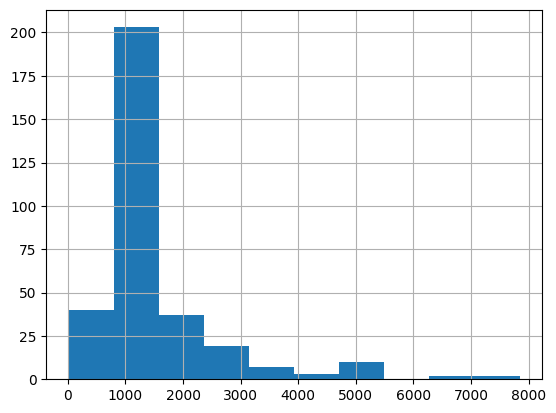

In [10]:
import tiktoken

# Load the cl100k_base tokenizer which is designed to work with the ada-002 model
tokenizer = tiktoken.get_encoding("cl100k_base")

df = pd.read_csv('processed/scraped.csv', index_col=0)
df.columns = ['title', 'text']

# Tokenize the text and save the number of tokens to a new column
df['n_tokens'] = df.text.apply(lambda x: len(tokenizer.encode(x)))

# Visualize the distribution of the number of tokens per row using a histogram
df.n_tokens.hist()

In [18]:
max_tokens = 500

# Function to split the text into chunks of a maximum number of tokens
def split_into_many(text, max_tokens = max_tokens):

    # Split the text into sentences
    sentences = text.split('. ')

    # Get the number of tokens for each sentence
    n_tokens = [len(tokenizer.encode(" " + sentence)) for sentence in sentences]

    chunks = []
    tokens_so_far = 0
    chunk = []

    # Loop through the sentences and tokens joined together in a tuple
    for sentence, token in zip(sentences, n_tokens):

        # If the number of tokens so far plus the number of tokens in the current sentence is greater
        # than the max number of tokens, then add the chunk to the list of chunks and reset
        # the chunk and tokens so far
        if tokens_so_far + token > max_tokens:
            chunks.append(". ".join(chunk) + ".")
            chunk = []
            tokens_so_far = 0

        # If the number of tokens in the current sentence is greater than the max number of
        # tokens, go to the next sentence
        if token > max_tokens:
            continue

        # Otherwise, add the sentence to the chunk and add the number of tokens to the total
        chunk.append(sentence)
        tokens_so_far += token + 1

    return chunks


shortened = []

# Loop through the dataframe
for row in df.iterrows():

    # If the text is None, go to the next row
    if row[1]['text'] is None:
        continue

    # If the number of tokens is greater than the max number of tokens, split the text into chunks
    if row[1]['n_tokens'] > max_tokens:
        shortened += split_into_many(row[1]['text'])

    # Otherwise, add the text to the list of shortened texts
    else:
        shortened.append( row[1]['text'] )

KeyError: 'n_tokens'

<Axes: >

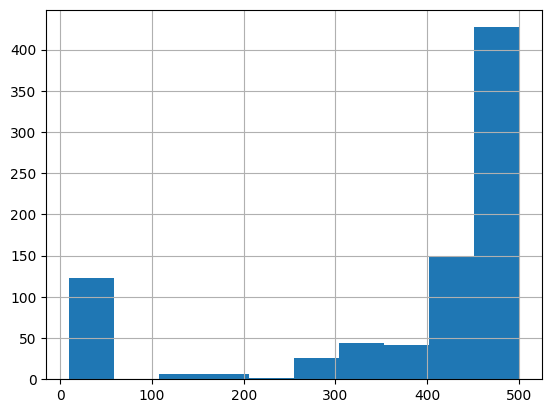

In [12]:
df = pd.DataFrame(shortened, columns = ['text'])
df['n_tokens'] = df.text.apply(lambda x: len(tokenizer.encode(x)))
df.n_tokens.hist()

In [34]:
import openai
import os
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

# Access the API key
openai.api_key = os.getenv("OPENAI_API_KEY")

df['embeddings'] = df.text.apply(lambda x: openai.Embedding.create(input=x, engine='text-embedding-ada-002')['data'][0]['embedding'])

df.to_csv('processed/embeddings.csv')
df.head()






InvalidRequestError: This model's maximum context length is 8191 tokens, however you requested 8218 tokens (8218 in your prompt; 0 for the completion). Please reduce your prompt; or completion length.

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010 entries, 0 to 1009
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   fname   1010 non-null   object
 1   text    1010 non-null   object
dtypes: object(2)
memory usage: 15.9+ KB
